In [3]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import matplotlib.pyplot as plt

csv_firm_data = Path.cwd().parent.parent / "Data/Firm_variables/firmcharacteristics.csv"
parquet_file = (Path.cwd().parent.parent / "Data/Firm_variables/firmcharacteristics")

data_path = Path.cwd().parent.parent / "Data"

firm_tickers = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "WMT", "COST", "BKNG", "EXPE", "COHR", "HD", "AAPL"]
firm_permno = [10107, 84788, 86580, 13407, 93436, 55976, 87055, 86783, 90808, 24476, 66181, 14593]

period = [datetime.datetime(2018, 12, 31), datetime.datetime(2021, 12, 31)]
number_of_sso = len(firm_tickers)

In [4]:
pl.read_csv(csv_firm_data, separator = ",",try_parse_dates = True).estimated_size("mb")

2943.7515325546265

In [5]:
df = pl.scan_csv(csv_firm_data, separator=",")
df.schema
df.fetch(5)

shape: (5, 97)
┌────────┬──────────┬───────────┬──────────┬───┬────────────┬──────────┬───────────┬──────┐
│ permno ┆ DATE     ┆ mvel1     ┆ beta     ┆ … ┆ std_dolvol ┆ std_turn ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---        ┆ ---      ┆ ---       ┆ ---  │
│ i64    ┆ i64      ┆ f64       ┆ f64      ┆   ┆ f64        ┆ f64      ┆ f64       ┆ f64  │
╞════════╪══════════╪═══════════╪══════════╪═══╪════════════╪══════════╪═══════════╪══════╡
│ 10006  ┆ 19570131 ┆ 82249.0   ┆ 1.122846 ┆ … ┆ 0.355638   ┆ 0.46042  ┆ 1.1210e-7 ┆ 37.0 │
│ 10014  ┆ 19570131 ┆ 3903.375  ┆ 0.426734 ┆ … ┆ 1.152126   ┆ 1.16961  ┆ 9.2291e-8 ┆ null │
│ 10022  ┆ 19570131 ┆ 9273.25   ┆ 1.066449 ┆ … ┆ 0.815777   ┆ 0.679803 ┆ 1.1818e-7 ┆ null │
│ 10030  ┆ 19570131 ┆ 54465.875 ┆ 0.926038 ┆ … ┆ 0.739302   ┆ 1.333656 ┆ 6.1267e-8 ┆ null │
│ 10057  ┆ 19570131 ┆ 40250.0   ┆ 1.247748 ┆ … ┆ 0.75551    ┆ 0.410391 ┆ 3.31579   ┆ null │
└────────┴──────────┴───────────┴──────────┴───┴────────────┴──────────┴───────────┴──────┘

In [4]:
# df.select(pl.col("DATE")).cast(5)
# df_filter_10006 = df.filter(pl.col("permno") == 10006)
# df_test = df_filter_10006.cast({"DATE" : pl.Datetime})

In [6]:
for col_name in df.columns:
    if col_name != "DATE":
        df = df.cast({col_name: pl.Float64})

datetime_cols = ["DATE"]
int_cols = ["permno"]

df = df.cast({"permno":pl.Int64})

df_new = df.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias('DATE'))

# df_new = df.cast({"DATE":pl.Date})

# df_new = df.select(pl.col("DATE").cast(pl.Date)).dt.year()


In [7]:
df_new.fetch(10)

shape: (10, 97)
┌────────┬────────────┬────────────┬──────────┬───┬────────────┬──────────┬───────────┬──────┐
│ permno ┆ DATE       ┆ mvel1      ┆ beta     ┆ … ┆ std_dolvol ┆ std_turn ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---        ┆ ---      ┆ ---       ┆ ---  │
│ i64    ┆ date       ┆ f64        ┆ f64      ┆   ┆ f64        ┆ f64      ┆ f64       ┆ f64  │
╞════════╪════════════╪════════════╪══════════╪═══╪════════════╪══════════╪═══════════╪══════╡
│ 10006  ┆ 1957-01-31 ┆ 82249.0    ┆ 1.122846 ┆ … ┆ 0.355638   ┆ 0.46042  ┆ 1.1210e-7 ┆ 37.0 │
│ 10014  ┆ 1957-01-31 ┆ 3903.375   ┆ 0.426734 ┆ … ┆ 1.152126   ┆ 1.16961  ┆ 9.2291e-8 ┆ null │
│ 10022  ┆ 1957-01-31 ┆ 9273.25    ┆ 1.066449 ┆ … ┆ 0.815777   ┆ 0.679803 ┆ 1.1818e-7 ┆ null │
│ 10030  ┆ 1957-01-31 ┆ 54465.875  ┆ 0.926038 ┆ … ┆ 0.739302   ┆ 1.333656 ┆ 6.1267e-8 ┆ null │
│ 10057  ┆ 1957-01-31 ┆ 40250.0    ┆ 1.247748 ┆ … ┆ 0.75551    ┆ 0.410391 ┆ 3.31579   ┆ null │
│ 10065  ┆ 1957-01-31 ┆ 76945.25   ┆ 1.264106 ┆ … ┆ 0.561265   ┆ 0.461107 ┆ 1.6874e-7 ┆ null │
│ 10102  ┆ 1957-01-31 ┆ 186193.5   ┆ 1.445027 ┆ … ┆ 0.78771    ┆ 0.77336  ┆ 1.5303e-7 ┆ 28.0 │
│ 10137  ┆ 1957-01-31 ┆ 225984.0   ┆ 0.585546 ┆ … ┆ 0.597666   ┆ 0.106998 ┆ 6.6165e-7 ┆ 49.0 │
│ 10145  ┆ 1957-01-31 ┆ 962994.375 ┆ 1.13221  ┆ … ┆ 0.410964   ┆ 0.174574 ┆ 2.8306e-7 ┆ 99.0 │
│ 10153  ┆ 1957-01-31 ┆ 279846.875 ┆ 1.173314 ┆ … ┆ 0.452489   ┆ 0.527789 ┆ 1.0006e-7 ┆ 13.0 │
└────────┴────────────┴────────────┴──────────┴───┴────────────┴──────────┴───────────┴──────┘

In [8]:
df_filter = df_new.filter(pl.col("permno").is_in(firm_permno))

In [10]:
df_filter.collect().approx_n_unique()


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/1837573349.py:1: DeprecationWarning: `approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  df_filter.collect().approx_n_unique()


shape: (1, 97)
┌────────┬──────┬───────┬──────┬───┬────────────┬──────────┬───────────┬──────┐
│ permno ┆ DATE ┆ mvel1 ┆ beta ┆ … ┆ std_dolvol ┆ std_turn ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---  ┆ ---   ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---       ┆ ---  │
│ u32    ┆ u32  ┆ u32   ┆ u32  ┆   ┆ u32        ┆ u32      ┆ u32       ┆ u32  │
╞════════╪══════╪═══════╪══════╪═══╪════════════╪══════════╪═══════════╪══════╡
│ 12     ┆ 586  ┆ 4216  ┆ 4146 ┆ … ┆ 4171       ┆ 4185     ┆ 4151      ┆ 8    │
└────────┴──────┴───────┴──────┴───┴────────────┴──────────┴───────────┴──────┘

In [9]:
df_filter.fetch(10)

shape: (0, 97)
┌────────┬──────┬───────┬──────┬───┬────────────┬──────────┬───────────┬──────┐
│ permno ┆ DATE ┆ mvel1 ┆ beta ┆ … ┆ std_dolvol ┆ std_turn ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---  ┆ ---   ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---       ┆ ---  │
│ i64    ┆ date ┆ f64   ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64       ┆ f64  │
╞════════╪══════╪═══════╪══════╪═══╪════════════╪══════════╪═══════════╪══════╡
└────────┴──────┴───────┴──────┴───┴────────────┴──────────┴───────────┴──────┘

In [11]:
# Saving file
data_path_parq = Path.cwd().parent.parent / "Data/Firm_variables/firm_data_new.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_path_parq):
    df_filter.sink_parquet(data_path_parq)

In [12]:
df = pl.read_parquet(data_path_parq)
df.estimated_size("mb")

3.2147159576416016

In [13]:
df

shape: (4_303, 97)
┌────────┬────────────┬────────────┬──────────┬───┬────────────┬───────────┬───────────┬──────┐
│ permno ┆ DATE       ┆ mvel1      ┆ beta     ┆ … ┆ std_dolvol ┆ std_turn  ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---  │
│ i64    ┆ date       ┆ f64        ┆ f64      ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64  │
╞════════╪════════════╪════════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪══════╡
│ 55976  ┆ 1972-12-29 ┆ 210044.25  ┆ null     ┆ … ┆ 1.405262   ┆ 0.683686  ┆ 0.000001  ┆ 53.0 │
│ 24476  ┆ 1973-01-31 ┆ 31747.5    ┆ null     ┆ … ┆ null       ┆ null      ┆ null      ┆ 38.0 │
│ 55976  ┆ 1973-01-31 ┆ 224698.5   ┆ null     ┆ … ┆ 1.182489   ┆ 0.714317  ┆ 2.6219e-7 ┆ 53.0 │
│ 24476  ┆ 1973-02-28 ┆ 32577.5    ┆ null     ┆ … ┆ null       ┆ null      ┆ null      ┆ 38.0 │
│ 55976  ┆ 1973-02-28 ┆ 192947.625 ┆ null     ┆ … ┆ 0.688489   ┆ 0.278791  ┆ 1.0       ┆ 53.0 │
│ …      ┆ …          ┆ …          ┆ …        ┆ … ┆ …          ┆ …         ┆ …         ┆ …    │
│ 86580  ┆ 2021-12-31 ┆ 8.1690e8   ┆ 0.954064 ┆ … ┆ 0.467636   ┆ 9.23609   ┆ 4.8307e-9 ┆ 36.0 │
│ 86783  ┆ 2021-12-31 ┆ 8.6308e7   ┆ 1.089129 ┆ … ┆ 0.301031   ┆ 3.412154  ┆ 9.6579e-9 ┆ 73.0 │
│ 87055  ┆ 2021-12-31 ┆ 2.3918e8   ┆ 0.32458  ┆ … ┆ 0.311283   ┆ 1.530727  ┆ 2.1591e-8 ┆ 53.0 │
│ 90808  ┆ 2021-12-31 ┆ 2.3520e7   ┆ 1.627042 ┆ … ┆ 0.581769   ┆ 16.761293 ┆ 4.3897e-9 ┆ 47.0 │
│ 93436  ┆ 2021-12-31 ┆ 1.1496e9   ┆ 1.504264 ┆ … ┆ 0.381912   ┆ 11.699841 ┆ 3.2401e-9 ┆ 37.0 │
└────────┴────────────┴────────────┴──────────┴───┴────────────┴───────────┴───────────┴──────┘

# Dates missing values

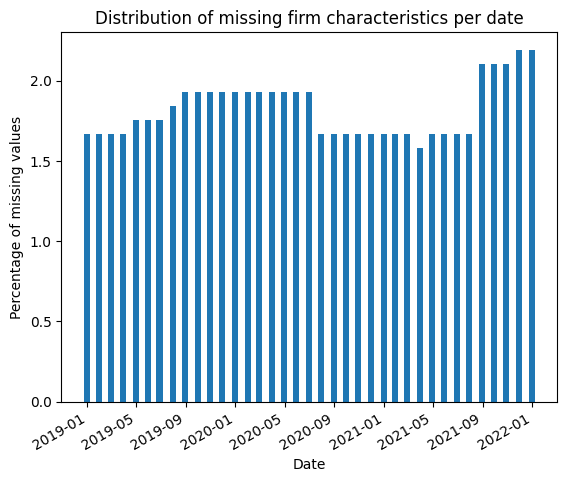

In [14]:
dataseries = df.sort("DATE").sort("permno")

dataseries = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

dataseries_pd = dataseries.to_pandas()

missing_values = []

for date in dataseries_pd['DATE'].unique():
    missing_count = dataseries_pd[dataseries_pd['DATE'] == date].isnull().sum().sum()
    missing_values.append({'Date': date, 'Missing Values': missing_count})

missing_values_df = pd.DataFrame(missing_values)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

#Percentage of missing values
missing_values_percentage = (missing_values_df["Missing Values"]/(95*number_of_sso)*100)

# Plot a histogram of 'days_till_exp'
ax.bar(missing_values_df['Date'], missing_values_percentage, width=15)  

# # Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Distribution of missing firm characteristics per date')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

# # Show the plot
plt.show()

In [15]:
dataseries

shape: (444, 97)
┌────────┬────────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬──────┐
│ permno ┆ DATE       ┆ mvel1    ┆ beta     ┆ … ┆ std_dolvol ┆ std_turn  ┆ zerotrade ┆ sic2 │
│ ---    ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---  │
│ i64    ┆ date       ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64  │
╞════════╪════════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪══════╡
│ 10107  ┆ 2018-12-31 ┆ 8.5122e8 ┆ 0.792636 ┆ … ┆ 0.297463   ┆ 1.292838  ┆ 2.2213e-8 ┆ 73.0 │
│ 10107  ┆ 2019-01-31 ┆ 7.8036e8 ┆ 0.814186 ┆ … ┆ 0.282718   ┆ 2.374113  ┆ 1.8718e-8 ┆ 73.0 │
│ 10107  ┆ 2019-02-28 ┆ 8.0121e8 ┆ 0.832455 ┆ … ┆ 0.207914   ┆ 1.0357    ┆ 2.2408e-8 ┆ 73.0 │
│ 10107  ┆ 2019-03-29 ┆ 8.5952e8 ┆ 0.778968 ┆ … ┆ 0.193236   ┆ 0.636321  ┆ 3.7678e-8 ┆ 73.0 │
│ 10107  ┆ 2019-04-30 ┆ 9.0413e8 ┆ 0.805571 ┆ … ┆ 0.265477   ┆ 1.045062  ┆ 2.7120e-8 ┆ 73.0 │
│ …      ┆ …          ┆ …        ┆ …        ┆ … ┆ …          ┆ …         ┆ …         ┆ …    │
│ 93436  ┆ 2021-08-31 ┆ 6.8034e8 ┆ 1.461826 ┆ … ┆ 0.265651   ┆ 5.539199  ┆ 4.5935e-9 ┆ 37.0 │
│ 93436  ┆ 2021-09-30 ┆ 7.3702e8 ┆ 1.454301 ┆ … ┆ 0.27542    ┆ 5.274786  ┆ 5.2095e-9 ┆ 37.0 │
│ 93436  ┆ 2021-10-29 ┆ 7.7858e8 ┆ 1.436531 ┆ … ┆ 0.273759   ┆ 4.970871  ┆ 5.3667e-9 ┆ 37.0 │
│ 93436  ┆ 2021-11-30 ┆ 1.1188e9 ┆ 1.508117 ┆ … ┆ 0.551016   ┆ 14.071951 ┆ 3.9741e-9 ┆ 37.0 │
│ 93436  ┆ 2021-12-31 ┆ 1.1496e9 ┆ 1.504264 ┆ … ┆ 0.381912   ┆ 11.699841 ┆ 3.2401e-9 ┆ 37.0 │
└────────┴────────────┴──────────┴──────────┴───┴────────────┴───────────┴───────────┴──────┘

[]

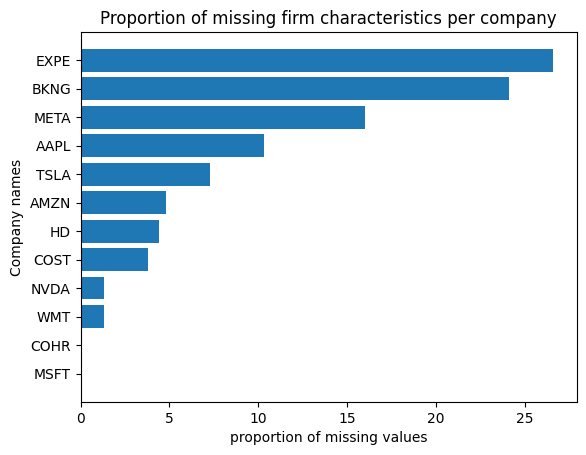

In [16]:
dataseries = df.sort("DATE").sort("permno")

dataseries = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

dataseries_pd = dataseries.to_pandas()

total_missing = dataseries_pd.isnull().sum().sum()

missing_values = []

for permn in dataseries_pd['permno'].unique():
    missing_count = dataseries_pd[dataseries_pd['permno'] == permn].isnull().sum().sum()
    missing_values.append({'Permno': permn, 'Missing Values': missing_count})

missing_values_df = pd.DataFrame(missing_values).sort_values(by='Missing Values', ascending=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

#Percentage of missing values
missing_values_percentage = (missing_values_df["Missing Values"]/total_missing*100)
# missing_values_percentage = missing_values_percentage.sort_values()
# Create a dictionary mapping permno to ticker
permno_to_ticker = {permno: ticker for permno, ticker in zip(firm_permno, firm_tickers)}

# Convert the numbers to their corresponding names
firm_names = [permno_to_ticker.get(permno) for permno in missing_values_df['Permno']]

# Plot a histogram of 'days_till_exp'
ax.barh(firm_names, missing_values_percentage, height=0.8)  

# # Add labels and title
ax.set_xlabel('proportion of missing values')
ax.set_ylabel('Company names')
ax.set_title('Proportion of missing firm characteristics per company')

plt.plot()

In [17]:
dataseries_pd

permno       DATE         mvel1      beta    betasq     chmom     dolvol  \
0     10107 2018-12-31  8.512159e+08  0.792636  0.628272 -0.053782  18.839129   
1     10107 2019-01-31  7.803623e+08  0.814186  0.662899 -0.124721  18.732203   
2     10107 2019-02-28  8.012092e+08  0.832455  0.692982 -0.134055  18.717804   
3     10107 2019-03-29  8.595180e+08  0.778968  0.606792 -0.201941  18.795006   
4     10107 2019-04-30  9.041281e+08  0.805571  0.648944 -0.223381  18.677404   
..      ...        ...           ...       ...       ...       ...        ...   
439   93436 2021-08-31  6.803383e+08  1.461826  2.136934 -1.907103  19.223606   
440   93436 2021-09-30  7.370200e+08  1.454301  2.114992 -0.266406  18.968600   
441   93436 2021-10-29  7.785819e+08  1.436531  2.063623 -0.395890  19.031238   
442   93436 2021-11-30  1.118751e+09  1.508117  2.274417 -0.258012  19.042739   
443   93436 2021-12-31  1.149642e+09  1.504264  2.262812  0.729456  18.992410   

      idiovol    indmom     mom1m  ...     stdcf   ms  baspread           ill  \
0    0.019609  0.083138  0.042505  ...  0.217246  6.0  0.024451  3.878408e-12   
1    0.020571  0.070997 -0.084047  ...  0.215009  6.0  0.038259  4.143449e-12   
2    0.020039 -0.077373  0.028158  ...  0.215009  6.0  0.020370  4.108051e-12   
3    0.020226  0.042863  0.077181  ...  0.215009  6.0  0.014431  3.131392e-12   
4    0.019627  0.114413  0.052754  ...  0.220843  6.0  0.015788  2.383012e-12   
..        ...       ...       ...  ...       ...  ...       ...           ...   
439  0.085674  0.848168  0.011034  ...  0.178304  6.0  0.036227  1.108349e-12   
440  0.084132  0.647541  0.070605  ...  0.178304  6.0  0.026900  1.302815e-12   
441  0.079950  0.652689  0.054042  ...  0.181713  6.0  0.025149  7.818319e-13   
442  0.079768  0.594775  0.436530  ...  0.181713  6.0  0.031566  7.860388e-13   
443  0.081092  0.223504  0.027612  ...  0.181713  6.0  0.056249  9.679103e-13   

       maxret    retvol  std_dolvol   std_turn     zerotrade  sic2  
0    0.039361  0.020227    0.297463   1.292838  2.221272e-08  73.0  
1    0.068310  0.027229    0.282718   2.374113  1.871815e-08  73.0  
2    0.046509  0.019790    0.207914   1.035700  2.240790e-08  73.0  
3    0.028799  0.011382    0.193236   0.636321  3.767796e-08  73.0  
4    0.022975  0.010915    0.265477   1.045062  2.712024e-08  73.0  
..        ...       ...         ...        ...           ...   ...  
439  0.046941  0.020875    0.265651   5.539199  4.593460e-09  37.0  
440  0.038279  0.021313    0.275420   5.274786  5.209458e-09  37.0  
441  0.027533  0.015922    0.273759   4.970871  5.366691e-09  37.0  
442  0.126616  0.028839    0.551016  14.071951  3.974110e-09  37.0  
443  0.084910  0.044202    0.381912  11.699841  3.240135e-09  37.0  

[444 rows x 97 columns]

# Columns containing missing values #

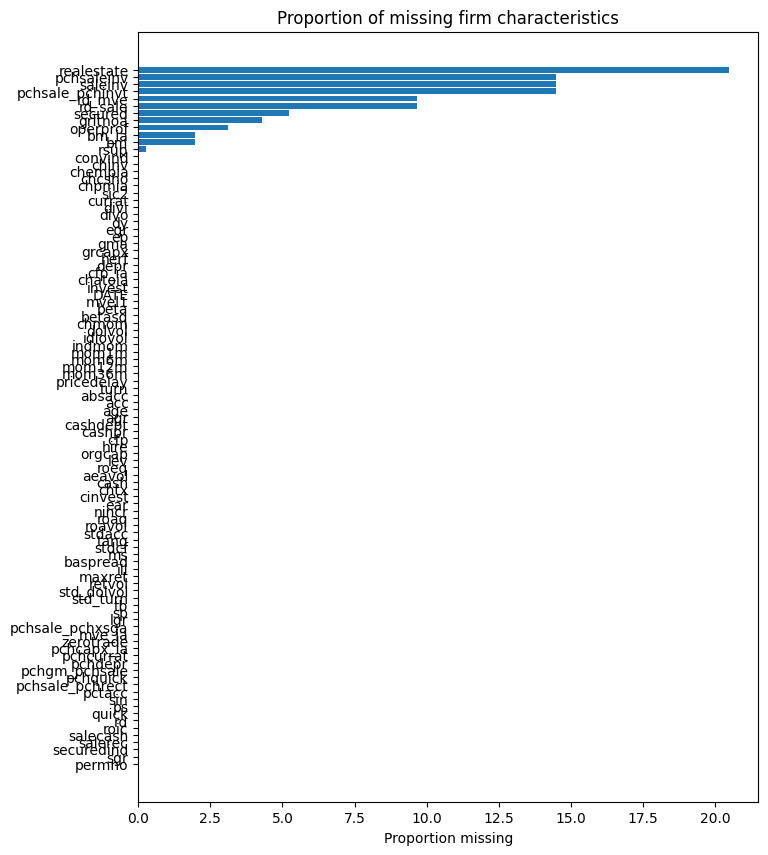

In [18]:
import matplotlib.pyplot as plt

# Total missing firm characteristics
total_missing = dataseries_pd.isnull().sum().sum()
# Get the column names
column_names = dataseries_pd.columns.tolist()

# pandas_df = dataseries_pd.to_pandas()
pandas_df = dataseries_pd.isna().sum()

pandas_df

# Transpose the DataFrame
transposed_df = pandas_df.T

# Sort the DataFrame by the first row
sorted_df = transposed_df.sort_values(ascending = True)

sorted_df
# Transpose the DataFrame back
sorted_df = sorted_df.T

# list_y = sorted_df.columns.tolist()
list_y = (sorted_df.values / total_missing * 100).tolist()
column_names = sorted_df.index.tolist()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8,10))

# Plot a horizontal bar plot of unique counts
ax.barh(column_names, list_y)

# Add labels and title
ax.set_xlabel('Proportion missing')
# ax.set_ylabel('Variables')
ax.set_title('Proportion of missing firm characteristics')

# plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
plt.rc('font', size=8)          # controls default text sizes

# Show the plot
plt.show()



# Insert the median in the missing data

In [19]:
complete_dataseries = dataseries_pd.copy()

# Ensure DATE is in datetime format
complete_dataseries['DATE'] = pd.to_datetime(complete_dataseries['DATE'])

# Extract month from the date
complete_dataseries['month'] = complete_dataseries['DATE'].dt.to_period('M')

# Initialize an empty DataFrame to store the results
results = pd.DataFrame()

def replace_with_median(df):
    # Iterate over the columns to find and replace median values
    for column in df.columns:
        if column.endswith('_median'):
            original_column = column.replace('_median', '')
            # if original_column in df.columns:
            #     df[original_column] = df[column]
            # Drop the '_median' column
            df.drop(columns=[column], inplace=True)
    return df

# Iterate over each unique permno
for permno in complete_dataseries['permno'].unique():
    # Select the rows for the current permno
    df_ticker = complete_dataseries[complete_dataseries['permno'] == permno]
    
    # Select the rows for other permnos
    df_other = complete_dataseries[complete_dataseries['permno'] != permno]
    
    # Group by month and calculate the median for each predictor variable for other stocks
    monthly_medians = df_other.groupby('month').median().reset_index()
    
    # Merge the calculated medians with the original DataFrame for the current permno
    df_ticker = df_ticker.merge(monthly_medians, on='month', suffixes=('', '_median'))
    
    # Append the result to the results DataFrame
    results = pd.concat([results, df_ticker], ignore_index=True)

# Remove the auxiliary 'month' column
results.drop(columns=['month'], inplace=True)

# Proceed with your existing code to resample and interpolate missing values
complete_dataseries = results.copy()

single_dataseries = complete_dataseries[complete_dataseries['permno'] == 10107].copy()
permnos = complete_dataseries['permno'].unique()

# Initialize an empty list to store the DataFrames
all_daily_dfs = []

# Iterate over the unique 'permno' values
for permno in permnos:
    # Select the rows with the current 'permno' value
    df = complete_dataseries[complete_dataseries['permno'] == permno].copy()
    
    # Convert 'DATE' to datetime and set it as the index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    
    # Resample to daily data
    daily_df = df.resample('D').asfreq()

    # Fill missing 'permno' values with the current 'permno'
    daily_df['permno'] = daily_df['permno'].fillna(permno)
    
    # Interpolate missing values
    for column in daily_df.columns:
        if column != 'permno': # Exclude 'permno'
                daily_df[column] = daily_df[column].interpolate(method='linear')
    
    # Append the DataFrame to 'all_daily_dfs'
    all_daily_dfs.append(daily_df)

# Concatenate all the DataFrames in 'all_daily_dfs'
all_daily_dfs = pd.concat(all_daily_dfs)

# Reset the index of 'all_daily_dfs'
all_daily_dfs.reset_index(inplace=True)

columns_to_drop = ['permno_median', 'DATE_median']

print(all_daily_dfs.nunique())

for column in columns_to_drop:
    if column in df.columns:
        df.drop(columns=column, inplace=True)

print(all_daily_dfs.nunique())
all_daily_dfs = replace_with_median(all_daily_dfs)
# Display the results
print(all_daily_dfs.nunique())
all_daily_dfs.sort_values(by=['permno', 'DATE'])


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/1181922570.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_daily_dfs.reset_index(inplace=True)


DATE                  1097
permno                  12
mvel1                13164
beta                 13164
betasq               13164
                     ...  
retvol_median         3960
std_dolvol_median     4314
std_turn_median       4254
zerotrade_median      3608
sic2_median              2
Length: 194, dtype: int64
DATE                  1097
permno                  12
mvel1                13164
beta                 13164
betasq               13164
                     ...  
retvol_median         3960
std_dolvol_median     4314
std_turn_median       4254
zerotrade_median      3608
sic2_median              2
Length: 194, dtype: int64
DATE           1097
permno           12
mvel1         13164
beta          13164
betasq        13164
              ...  
retvol        13164
std_dolvol    13164
std_turn      13164
zerotrade     13164
sic2              8
Length: 97, dtype: int64


DATE   permno         mvel1      beta    betasq     chmom  \
0     2018-12-31  10107.0  8.512159e+08  0.792636  0.628272 -0.053782   
1     2019-01-01  10107.0  8.489303e+08  0.793332  0.629389 -0.056070   
2     2019-01-02  10107.0  8.466447e+08  0.794027  0.630506 -0.058358   
3     2019-01-03  10107.0  8.443591e+08  0.794722  0.631623 -0.060647   
4     2019-01-04  10107.0  8.420735e+08  0.795417  0.632740 -0.062935   
...          ...      ...           ...       ...       ...       ...   
13159 2021-12-27  93436.0  1.145656e+09  1.504762  2.264309  0.602041   
13160 2021-12-28  93436.0  1.146653e+09  1.504637  2.263935  0.633895   
13161 2021-12-29  93436.0  1.147649e+09  1.504513  2.263560  0.665749   
13162 2021-12-30  93436.0  1.148646e+09  1.504389  2.263186  0.697603   
13163 2021-12-31  93436.0  1.149642e+09  1.504264  2.262812  0.729456   

          dolvol   idiovol    indmom     mom1m  ...     stdcf   ms  baspread  \
0      18.839129  0.019609  0.083138  0.042505  ...  0.217246  6.0  0.024451   
1      18.835680  0.019640  0.082746  0.038423  ...  0.217174  6.0  0.024897   
2      18.832231  0.019671  0.082355  0.034341  ...  0.217102  6.0  0.025342   
3      18.828781  0.019702  0.081963  0.030258  ...  0.217029  6.0  0.025788   
4      18.825332  0.019733  0.081571  0.026176  ...  0.216957  6.0  0.026233   
...          ...       ...       ...       ...  ...       ...  ...       ...   
13159  18.998904  0.080921  0.271410  0.080376  ...  0.181713  6.0  0.053064   
13160  18.997280  0.080964  0.259433  0.067185  ...  0.181713  6.0  0.053860   
13161  18.995657  0.081007  0.247457  0.053994  ...  0.181713  6.0  0.054656   
13162  18.994033  0.081050  0.235480  0.040803  ...  0.181713  6.0  0.055453   
13163  18.992410  0.081092  0.223504  0.027612  ...  0.181713  6.0  0.056249   

                ill    maxret    retvol  std_dolvol   std_turn     zerotrade  \
0      3.878408e-12  0.039361  0.020227    0.297463   1.292838  2.221272e-08   
1      3.886958e-12  0.040295  0.020453    0.296987   1.327718  2.209999e-08   
2      3.895507e-12  0.041229  0.020679    0.296512   1.362598  2.198727e-08   
3      3.904057e-12  0.042163  0.020905    0.296036   1.397478  2.187454e-08   
4      3.912607e-12  0.043097  0.021131    0.295560   1.432358  2.176181e-08   
...             ...       ...       ...         ...        ...           ...   
13159  9.444430e-13  0.090292  0.042220    0.403732  12.005920  3.334841e-09   
13160  9.503098e-13  0.088946  0.042715    0.398277  11.929400  3.311164e-09   
13161  9.561767e-13  0.087601  0.043211    0.392822  11.852880  3.287488e-09   
13162  9.620435e-13  0.086256  0.043706    0.387367  11.776361  3.263811e-09   
13163  9.679103e-13  0.084910  0.044202    0.381912  11.699841  3.240135e-09   

       sic2  
0      73.0  
1      73.0  
2      73.0  
3      73.0  
4      73.0  
...     ...  
13159  37.0  
13160  37.0  
13161  37.0  
13162  37.0  
13163  37.0  

[13164 rows x 97 columns]

## Add dates and the missing data of these days by linear

In [20]:
# Convert 'DATE' column to datetime format
all_daily_dfs['DATE'] = pd.to_datetime(all_daily_dfs['DATE'])

# Function to fill missing dates and interpolate values for each group
def fill_and_interpolate(group):
    # Generate a date range from the minimum date to the maximum date within the group
    date_range = pd.date_range(start=group['DATE'].min(), end=group['DATE'].max(), freq='D')
    # Create a DataFrame with the generated dates
    all_dates = pd.DataFrame({'DATE': date_range})
    # Merge the generated dates with the original group data
    group = pd.merge(all_dates, group, on='DATE', how='left')
    # Interpolate missing values linearly
    group = group.set_index('DATE').interpolate(method='linear').reset_index()
    # Fill remaining NaN values with backfill and forward fill
    group.fillna(method='bfill', inplace=True)
    group.fillna(method='ffill', inplace=True)
    return group

# Apply the function to each group
data_filled = all_daily_dfs.groupby('permno').apply(fill_and_interpolate).reset_index(drop=True)

# Add the original last rows to the data_filled DataFrame
last_rows = all_daily_dfs.groupby('permno').tail(1).reset_index(drop=True)
data_filled = pd.concat([data_filled, last_rows]).drop_duplicates(subset=['permno', 'DATE'], keep='last').reset_index(drop=True)

# Ensure that there are no NaN values after interpolation
data_filled = data_filled.set_index('DATE').interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').reset_index()


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/3795590643.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='bfill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/3795590643.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='ffill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/3795590643.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='bfill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/3795590643.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill(

In [21]:
data_filled

DATE   permno         mvel1      beta    betasq     chmom  \
0     2018-12-31  10107.0  8.512159e+08  0.792636  0.628272 -0.053782   
1     2019-01-01  10107.0  8.489303e+08  0.793332  0.629389 -0.056070   
2     2019-01-02  10107.0  8.466447e+08  0.794027  0.630506 -0.058358   
3     2019-01-03  10107.0  8.443591e+08  0.794722  0.631623 -0.060647   
4     2019-01-04  10107.0  8.420735e+08  0.795417  0.632740 -0.062935   
...          ...      ...           ...       ...       ...       ...   
13159 2021-12-31  86580.0  8.169000e+08  0.954064  0.910238  0.799398   
13160 2021-12-31  86783.0  8.630827e+07  1.089129  1.186203 -0.274184   
13161 2021-12-31  87055.0  2.391794e+08  0.324580  0.105352  0.435458   
13162 2021-12-31  90808.0  2.351978e+07  1.627042  2.647266 -0.511029   
13163 2021-12-31  93436.0  1.149642e+09  1.504264  2.262812  0.729456   

          dolvol   idiovol    indmom     mom1m  ...     stdcf   ms  baspread  \
0      18.839129  0.019609  0.083138  0.042505  ...  0.217246  6.0  0.024451   
1      18.835680  0.019640  0.082746  0.038423  ...  0.217174  6.0  0.024897   
2      18.832231  0.019671  0.082355  0.034341  ...  0.217102  6.0  0.025342   
3      18.828781  0.019702  0.081963  0.030258  ...  0.217029  6.0  0.025788   
4      18.825332  0.019733  0.081571  0.026176  ...  0.216957  6.0  0.026233   
...          ...       ...       ...       ...  ...       ...  ...       ...   
13159  18.992410  0.047273  0.346308  0.278054  ...  0.102293  6.0  0.050714   
13160  18.519486  0.035867  0.406290 -0.131747  ...  0.441071  3.0  0.030937   
13161  18.976582  0.026592  0.555692  0.097327  ...  0.058722  6.0  0.018605   
13162  17.825523  0.046460  0.203499 -0.020193  ...  0.948068  4.0  0.033633   
13163  18.992410  0.081092  0.223504  0.027612  ...  0.181713  6.0  0.056249   

                ill    maxret    retvol  std_dolvol   std_turn     zerotrade  \
0      3.878408e-12  0.039361  0.020227    0.297463   1.292838  2.221272e-08   
1      3.886958e-12  0.040295  0.020453    0.296987   1.327718  2.209999e-08   
2      3.895507e-12  0.041229  0.020679    0.296512   1.362598  2.198727e-08   
3      3.904057e-12  0.042163  0.020905    0.296036   1.397478  2.187454e-08   
4      3.912607e-12  0.043097  0.021131    0.295560   1.432358  2.176181e-08   
...             ...       ...       ...         ...        ...           ...   
13159  1.883162e-12  0.120423  0.040296    0.467636   9.236090  4.830736e-09   
13160  1.979236e-11  0.074665  0.028586    0.301031   3.412154  9.657866e-09   
13161  9.708006e-12  0.026457  0.012114    0.311283   1.530727  2.159084e-08   
13162  4.710676e-11  0.156268  0.046327    0.581769  16.761293  4.389694e-09   
13163  9.679103e-13  0.084910  0.044202    0.381912  11.699841  3.240135e-09   

       sic2  
0      73.0  
1      73.0  
2      73.0  
3      73.0  
4      73.0  
...     ...  
13159  36.0  
13160  73.0  
13161  53.0  
13162  47.0  
13163  37.0  

[13164 rows x 97 columns]

In [22]:


# Check for NaN values column-wise
nan_columns = data_filled.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
DATE          0
permno        0
mvel1         0
beta          0
betasq        0
             ..
retvol        0
std_dolvol    0
std_turn      0
zerotrade     0
sic2          0
Length: 97, dtype: int64
Columns with NaN values:
[]


In [23]:
print(data_filled.nunique())

DATE           1097
permno           12
mvel1         13164
beta          13164
betasq        13164
              ...  
retvol        13164
std_dolvol    13164
std_turn      13164
zerotrade     13164
sic2              8
Length: 97, dtype: int64


# Save the median linear data

In [24]:
# Saving file
data_median_path_parq = Path.cwd().parent.parent / "Data/Firm_variables/daily_firm_data_median_new.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_median_path_parq):
    data_filled.to_parquet(data_median_path_parq)

# Adding the Ticker to the data
df_ticker = pd.read_parquet(data_median_path_parq)

# Create a dictionary mapping permno to ticker
permno_to_ticker = {permno: ticker for permno, ticker in zip(firm_permno, firm_tickers)}

# Add a new column 'Firm Names' to the DataFrame
df_ticker['Ticker'] = df_ticker['permno'].map(permno_to_ticker)

In [25]:
all_daily_dfs

DATE   permno         mvel1      beta    betasq     chmom  \
0     2018-12-31  10107.0  8.512159e+08  0.792636  0.628272 -0.053782   
1     2019-01-01  10107.0  8.489303e+08  0.793332  0.629389 -0.056070   
2     2019-01-02  10107.0  8.466447e+08  0.794027  0.630506 -0.058358   
3     2019-01-03  10107.0  8.443591e+08  0.794722  0.631623 -0.060647   
4     2019-01-04  10107.0  8.420735e+08  0.795417  0.632740 -0.062935   
...          ...      ...           ...       ...       ...       ...   
13159 2021-12-27  93436.0  1.145656e+09  1.504762  2.264309  0.602041   
13160 2021-12-28  93436.0  1.146653e+09  1.504637  2.263935  0.633895   
13161 2021-12-29  93436.0  1.147649e+09  1.504513  2.263560  0.665749   
13162 2021-12-30  93436.0  1.148646e+09  1.504389  2.263186  0.697603   
13163 2021-12-31  93436.0  1.149642e+09  1.504264  2.262812  0.729456   

          dolvol   idiovol    indmom     mom1m  ...     stdcf   ms  baspread  \
0      18.839129  0.019609  0.083138  0.042505  ...  0.217246  6.0  0.024451   
1      18.835680  0.019640  0.082746  0.038423  ...  0.217174  6.0  0.024897   
2      18.832231  0.019671  0.082355  0.034341  ...  0.217102  6.0  0.025342   
3      18.828781  0.019702  0.081963  0.030258  ...  0.217029  6.0  0.025788   
4      18.825332  0.019733  0.081571  0.026176  ...  0.216957  6.0  0.026233   
...          ...       ...       ...       ...  ...       ...  ...       ...   
13159  18.998904  0.080921  0.271410  0.080376  ...  0.181713  6.0  0.053064   
13160  18.997280  0.080964  0.259433  0.067185  ...  0.181713  6.0  0.053860   
13161  18.995657  0.081007  0.247457  0.053994  ...  0.181713  6.0  0.054656   
13162  18.994033  0.081050  0.235480  0.040803  ...  0.181713  6.0  0.055453   
13163  18.992410  0.081092  0.223504  0.027612  ...  0.181713  6.0  0.056249   

                ill    maxret    retvol  std_dolvol   std_turn     zerotrade  \
0      3.878408e-12  0.039361  0.020227    0.297463   1.292838  2.221272e-08   
1      3.886958e-12  0.040295  0.020453    0.296987   1.327718  2.209999e-08   
2      3.895507e-12  0.041229  0.020679    0.296512   1.362598  2.198727e-08   
3      3.904057e-12  0.042163  0.020905    0.296036   1.397478  2.187454e-08   
4      3.912607e-12  0.043097  0.021131    0.295560   1.432358  2.176181e-08   
...             ...       ...       ...         ...        ...           ...   
13159  9.444430e-13  0.090292  0.042220    0.403732  12.005920  3.334841e-09   
13160  9.503098e-13  0.088946  0.042715    0.398277  11.929400  3.311164e-09   
13161  9.561767e-13  0.087601  0.043211    0.392822  11.852880  3.287488e-09   
13162  9.620435e-13  0.086256  0.043706    0.387367  11.776361  3.263811e-09   
13163  9.679103e-13  0.084910  0.044202    0.381912  11.699841  3.240135e-09   

       sic2  
0      73.0  
1      73.0  
2      73.0  
3      73.0  
4      73.0  
...     ...  
13159  37.0  
13160  37.0  
13161  37.0  
13162  37.0  
13163  37.0  

[13164 rows x 97 columns]

In [26]:
df_ticker

DATE   permno         mvel1      beta    betasq     chmom  \
0     2018-12-31  10107.0  8.512159e+08  0.792636  0.628272 -0.053782   
1     2019-01-01  10107.0  8.489303e+08  0.793332  0.629389 -0.056070   
2     2019-01-02  10107.0  8.466447e+08  0.794027  0.630506 -0.058358   
3     2019-01-03  10107.0  8.443591e+08  0.794722  0.631623 -0.060647   
4     2019-01-04  10107.0  8.420735e+08  0.795417  0.632740 -0.062935   
...          ...      ...           ...       ...       ...       ...   
13159 2021-12-31  86580.0  8.169000e+08  0.954064  0.910238  0.799398   
13160 2021-12-31  86783.0  8.630827e+07  1.089129  1.186203 -0.274184   
13161 2021-12-31  87055.0  2.391794e+08  0.324580  0.105352  0.435458   
13162 2021-12-31  90808.0  2.351978e+07  1.627042  2.647266 -0.511029   
13163 2021-12-31  93436.0  1.149642e+09  1.504264  2.262812  0.729456   

          dolvol   idiovol    indmom     mom1m  ...   ms  baspread  \
0      18.839129  0.019609  0.083138  0.042505  ...  6.0  0.024451   
1      18.835680  0.019640  0.082746  0.038423  ...  6.0  0.024897   
2      18.832231  0.019671  0.082355  0.034341  ...  6.0  0.025342   
3      18.828781  0.019702  0.081963  0.030258  ...  6.0  0.025788   
4      18.825332  0.019733  0.081571  0.026176  ...  6.0  0.026233   
...          ...       ...       ...       ...  ...  ...       ...   
13159  18.992410  0.047273  0.346308  0.278054  ...  6.0  0.050714   
13160  18.519486  0.035867  0.406290 -0.131747  ...  3.0  0.030937   
13161  18.976582  0.026592  0.555692  0.097327  ...  6.0  0.018605   
13162  17.825523  0.046460  0.203499 -0.020193  ...  4.0  0.033633   
13163  18.992410  0.081092  0.223504  0.027612  ...  6.0  0.056249   

                ill    maxret    retvol  std_dolvol   std_turn     zerotrade  \
0      3.878408e-12  0.039361  0.020227    0.297463   1.292838  2.221272e-08   
1      3.886958e-12  0.040295  0.020453    0.296987   1.327718  2.209999e-08   
2      3.895507e-12  0.041229  0.020679    0.296512   1.362598  2.198727e-08   
3      3.904057e-12  0.042163  0.020905    0.296036   1.397478  2.187454e-08   
4      3.912607e-12  0.043097  0.021131    0.295560   1.432358  2.176181e-08   
...             ...       ...       ...         ...        ...           ...   
13159  1.883162e-12  0.120423  0.040296    0.467636   9.236090  4.830736e-09   
13160  1.979236e-11  0.074665  0.028586    0.301031   3.412154  9.657866e-09   
13161  9.708006e-12  0.026457  0.012114    0.311283   1.530727  2.159084e-08   
13162  4.710676e-11  0.156268  0.046327    0.581769  16.761293  4.389694e-09   
13163  9.679103e-13  0.084910  0.044202    0.381912  11.699841  3.240135e-09   

       sic2  Ticker  
0      73.0    MSFT  
1      73.0    MSFT  
2      73.0    MSFT  
3      73.0    MSFT  
4      73.0    MSFT  
...     ...     ...  
13159  36.0    NVDA  
13160  73.0    BKNG  
13161  53.0    COST  
13162  47.0    EXPE  
13163  37.0    TSLA  

[13164 rows x 98 columns]

In [28]:
# Saving file with ticker
data_median_tick_path_parq = Path.cwd().parent.parent / "Data/Firm_variables/daily_firm_data_median_tick_new.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_median_tick_path_parq):
    df_ticker.to_parquet(data_median_tick_path_parq)

In [29]:
df_ticker

DATE   permno         mvel1      beta    betasq     chmom  \
0     2018-12-31  10107.0  8.512159e+08  0.792636  0.628272 -0.053782   
1     2019-01-01  10107.0  8.489303e+08  0.793332  0.629389 -0.056070   
2     2019-01-02  10107.0  8.466447e+08  0.794027  0.630506 -0.058358   
3     2019-01-03  10107.0  8.443591e+08  0.794722  0.631623 -0.060647   
4     2019-01-04  10107.0  8.420735e+08  0.795417  0.632740 -0.062935   
...          ...      ...           ...       ...       ...       ...   
13159 2021-12-31  86580.0  8.169000e+08  0.954064  0.910238  0.799398   
13160 2021-12-31  86783.0  8.630827e+07  1.089129  1.186203 -0.274184   
13161 2021-12-31  87055.0  2.391794e+08  0.324580  0.105352  0.435458   
13162 2021-12-31  90808.0  2.351978e+07  1.627042  2.647266 -0.511029   
13163 2021-12-31  93436.0  1.149642e+09  1.504264  2.262812  0.729456   

          dolvol   idiovol    indmom     mom1m  ...   ms  baspread  \
0      18.839129  0.019609  0.083138  0.042505  ...  6.0  0.024451   
1      18.835680  0.019640  0.082746  0.038423  ...  6.0  0.024897   
2      18.832231  0.019671  0.082355  0.034341  ...  6.0  0.025342   
3      18.828781  0.019702  0.081963  0.030258  ...  6.0  0.025788   
4      18.825332  0.019733  0.081571  0.026176  ...  6.0  0.026233   
...          ...       ...       ...       ...  ...  ...       ...   
13159  18.992410  0.047273  0.346308  0.278054  ...  6.0  0.050714   
13160  18.519486  0.035867  0.406290 -0.131747  ...  3.0  0.030937   
13161  18.976582  0.026592  0.555692  0.097327  ...  6.0  0.018605   
13162  17.825523  0.046460  0.203499 -0.020193  ...  4.0  0.033633   
13163  18.992410  0.081092  0.223504  0.027612  ...  6.0  0.056249   

                ill    maxret    retvol  std_dolvol   std_turn     zerotrade  \
0      3.878408e-12  0.039361  0.020227    0.297463   1.292838  2.221272e-08   
1      3.886958e-12  0.040295  0.020453    0.296987   1.327718  2.209999e-08   
2      3.895507e-12  0.041229  0.020679    0.296512   1.362598  2.198727e-08   
3      3.904057e-12  0.042163  0.020905    0.296036   1.397478  2.187454e-08   
4      3.912607e-12  0.043097  0.021131    0.295560   1.432358  2.176181e-08   
...             ...       ...       ...         ...        ...           ...   
13159  1.883162e-12  0.120423  0.040296    0.467636   9.236090  4.830736e-09   
13160  1.979236e-11  0.074665  0.028586    0.301031   3.412154  9.657866e-09   
13161  9.708006e-12  0.026457  0.012114    0.311283   1.530727  2.159084e-08   
13162  4.710676e-11  0.156268  0.046327    0.581769  16.761293  4.389694e-09   
13163  9.679103e-13  0.084910  0.044202    0.381912  11.699841  3.240135e-09   

       sic2  Ticker  
0      73.0    MSFT  
1      73.0    MSFT  
2      73.0    MSFT  
3      73.0    MSFT  
4      73.0    MSFT  
...     ...     ...  
13159  36.0    NVDA  
13160  73.0    BKNG  
13161  53.0    COST  
13162  47.0    EXPE  
13163  37.0    TSLA  

[13164 rows x 98 columns]

In [30]:


# Check for NaN values column-wise
nan_columns = df_ticker.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
DATE          0
permno        0
mvel1         0
beta          0
betasq        0
             ..
std_dolvol    0
std_turn      0
zerotrade     0
sic2          0
Ticker        0
Length: 98, dtype: int64
Columns with NaN values:
[]


# Plot of the data


In [31]:
group_sizes = all_daily_dfs.groupby(['permno']).size()
print(group_sizes)

permno
10107.0    1097
13407.0    1097
14593.0    1097
24476.0    1097
55976.0    1097
66181.0    1097
84788.0    1097
86580.0    1097
86783.0    1097
87055.0    1097
90808.0    1097
93436.0    1097
dtype: int64


In [32]:
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create a custom business day object that excludes weekends and US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Create a date range that only includes trading days
trading_days = pd.date_range(start=all_daily_dfs['DATE'].min(), end=all_daily_dfs['DATE'].max(), freq=us_bd)

# Convert 'DATE' to datetime if it's not already
all_daily_dfs['DATE'] = pd.to_datetime(all_daily_dfs['DATE'])

# Filter out the rows where 'DATE' is not a trading day
all_daily_dfs = all_daily_dfs[all_daily_dfs['DATE'].isin(trading_days)]

In [33]:
def standardize(series):
    # Map the ranks of the series into the [-1, 1] interval
    return 2.0 * (series.rank() / series.count() - 0.5)

# Select all columns except 'DATE' and 'permno'
columns_to_standardize = all_daily_dfs.columns.difference(['DATE', 'permno'])

# Group all_daily_dfs by 'permno' and 'DATE' and apply the standardize function to each group
pd_merged_standardized = all_daily_dfs.groupby(['permno'])[columns_to_standardize].apply(standardize)

# Reset the index to keep the 'permno' and 'DATE' columns
pd_merged_standardized.reset_index(inplace=True)

# Set 'DATE' and 'permno' as the index
pd_merged_standardized.set_index(['permno', all_daily_dfs['DATE']], inplace=True)

# Drop the 'level_1' column
pd_merged_standardized.drop('level_1', axis=1, inplace=True)

pd_merged_standardized

absacc       acc    aeavol       age       agr  \
permno  DATE                                                           
10107.0 2018-12-31  0.314741 -0.312085 -0.583001 -0.997344 -0.997344   
        2019-01-02  0.317397 -0.314741 -0.564409 -0.994688 -0.994688   
        2019-01-03  0.320053 -0.317397 -0.556441 -0.992032 -0.992032   
        2019-01-04  0.322709 -0.320053 -0.545817 -0.989376 -0.989376   
        2019-01-07  0.328021 -0.325365 -0.415671 -0.986720 -0.986720   
...                      ...       ...       ...       ...       ...   
93436.0 2021-12-23  0.861886 -0.859230 -0.586985  0.861886 -0.859230   
        2021-12-27  0.861886 -0.859230 -0.586985  0.861886 -0.859230   
        2021-12-28  0.861886 -0.859230 -0.586985  0.861886 -0.859230   
        2021-12-29  0.861886 -0.859230 -0.586985  0.861886 -0.859230   
        2021-12-30  0.861886 -0.859230 -0.586985  0.861886 -0.859230   

                    baspread      beta    betasq        bm     bm_ia  ...  \
permno  DATE                                                          ...   
10107.0 2018-12-31  0.580345  0.115538  0.115538  0.269588  0.256308  ...   
        2019-01-02  0.670651  0.126162  0.123506  0.282869  0.261620  ...   
        2019-01-03  0.686587  0.131474  0.128818  0.290837  0.264276  ...   
        2019-01-04  0.702523  0.136786  0.134130  0.296149  0.266932  ...   
        2019-01-07  0.734396  0.150066  0.144754  0.306773  0.274900  ...   
...                      ...       ...       ...       ...       ...  ...   
93436.0 2021-12-23  0.460823  0.952191  0.952191 -0.859230  0.918991  ...   
        2021-12-27  0.519256  0.949535  0.949535 -0.859230  0.918991  ...   
        2021-12-28  0.532537  0.946879  0.946879 -0.859230  0.918991  ...   
        2021-12-29  0.543161  0.944223  0.944223 -0.859230  0.918991  ...   
        2021-12-30  0.561753  0.941567  0.941567 -0.859230  0.918991  ...   

                         sin        sp  std_dolvol  std_turn    stdacc  \
permno  DATE                                                             
10107.0 2018-12-31  0.001328  1.000000    0.585657  0.492696  1.000000   
        2019-01-02  0.001328  0.997344    0.577689  0.551129  0.997344   
        2019-01-03  0.001328  0.994688    0.569721  0.585657  0.994688   
        2019-01-04  0.001328  0.992032    0.561753  0.620186  0.992032   
        2019-01-07  0.001328  0.989376    0.545817  0.697211  0.989376   
...                      ...       ...         ...       ...       ...   
93436.0 2021-12-23  0.001328 -0.859230    0.450199 -0.516600 -0.815405   
        2021-12-27  0.001328 -0.859230    0.349270 -0.537849 -0.815405   
        2021-12-28  0.001328 -0.859230    0.328021 -0.543161 -0.815405   
        2021-12-29  0.001328 -0.859230    0.296149 -0.545817 -0.815405   
        2021-12-30  0.001328 -0.859230    0.264276 -0.556441 -0.815405   

                       stdcf      tang        tb      turn  zerotrade  
permno  DATE                                                           
10107.0 2018-12-31  0.800797  0.333333 -0.349270  0.402390  -0.492696  
        2019-01-02  0.792829  0.335989 -0.346614  0.428951  -0.521912  
        2019-01-03  0.787517  0.338645 -0.343958  0.436919  -0.535193  
        2019-01-04  0.782205  0.341301 -0.338645  0.450199  -0.545817  
        2019-01-07  0.498008  0.343958 -0.328021  0.482072  -0.580345  
...                      ...       ...       ...       ...        ...  
93436.0 2021-12-23  0.945551  0.861886 -0.173971 -0.734396   0.620186  
        2021-12-27  0.945551  0.861886 -0.173971 -0.723772   0.598938  
        2021-12-28  0.945551  0.861886 -0.173971 -0.718459   0.590969  
        2021-12-29  0.945551  0.861886 -0.173971 -0.713147   0.580345  
        2021-12-30  0.945551  0.861886 -0.173971 -0.710491   0.572377  

[9036 rows x 95 columns]

In [32]:
# import pandas as pd

# def standardize_rank(series):
#     # Map the ranks of the series into the [-1, 1] interval
#     return 2.0 * (series.rank(method='average') / len(series) - 0.5)

# # Select all columns except 'DATE' and 'permno'
# columns_to_standardize = all_daily_dfs.columns.difference(['DATE', 'permno'])

# # Group by 'permno' and apply the standardize function to each group
# # Use .transform instead of .apply for correct reshaping
# standardized_values = all_daily_dfs.groupby('permno')[columns_to_standardize].transform(standardize_rank)

# # Ensure 'permno' and 'DATE' are preserved in the resulting dataframe
# standardized_values['permno'] = all_daily_dfs['permno']
# standardized_values['DATE'] = all_daily_dfs['DATE']

# # Set 'permno' and 'DATE' as the index
# standardized_values.set_index(['permno', 'DATE'], inplace=True)

# # The resulting DataFrame should now have standardized ranked values
# standardized_values


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


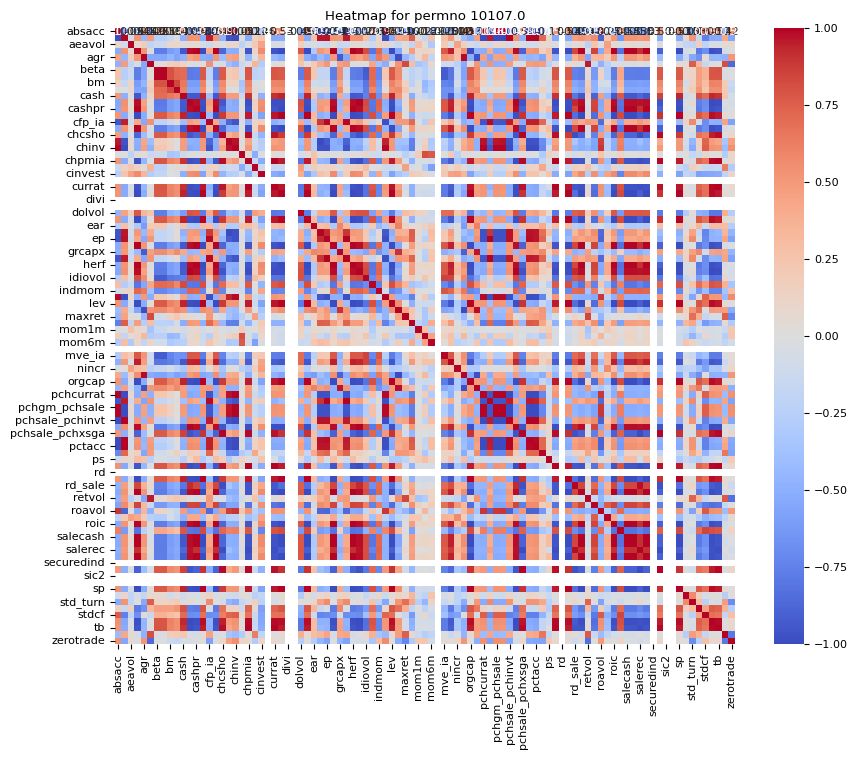

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


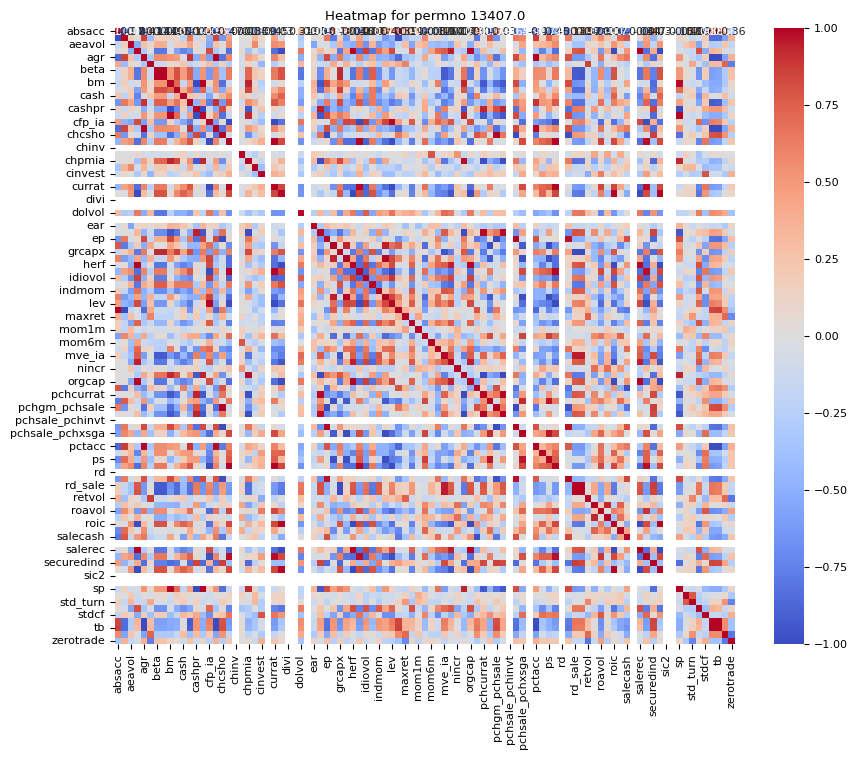

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


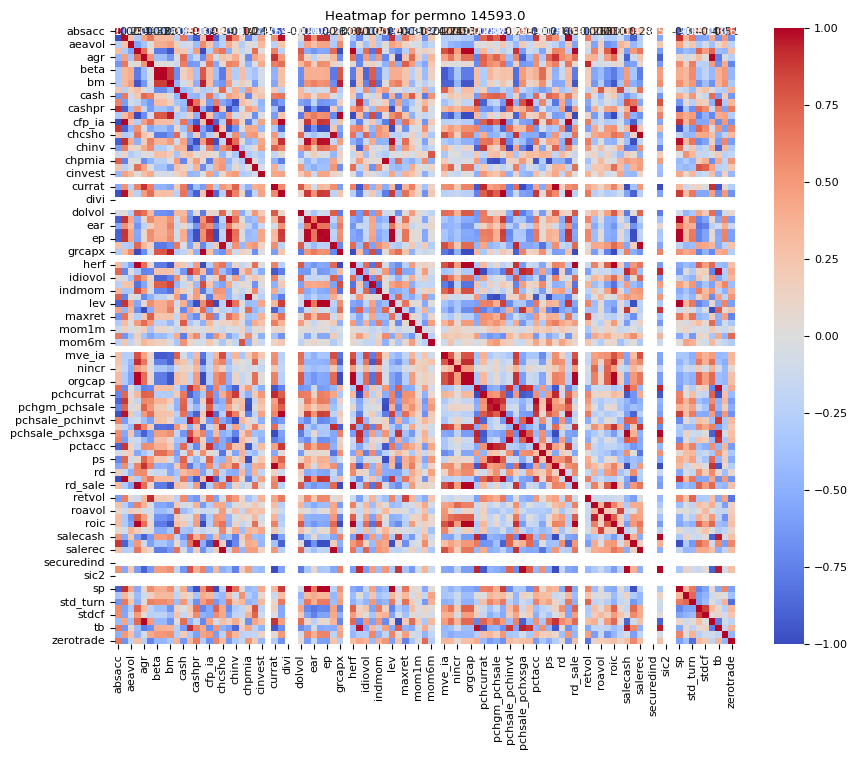

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


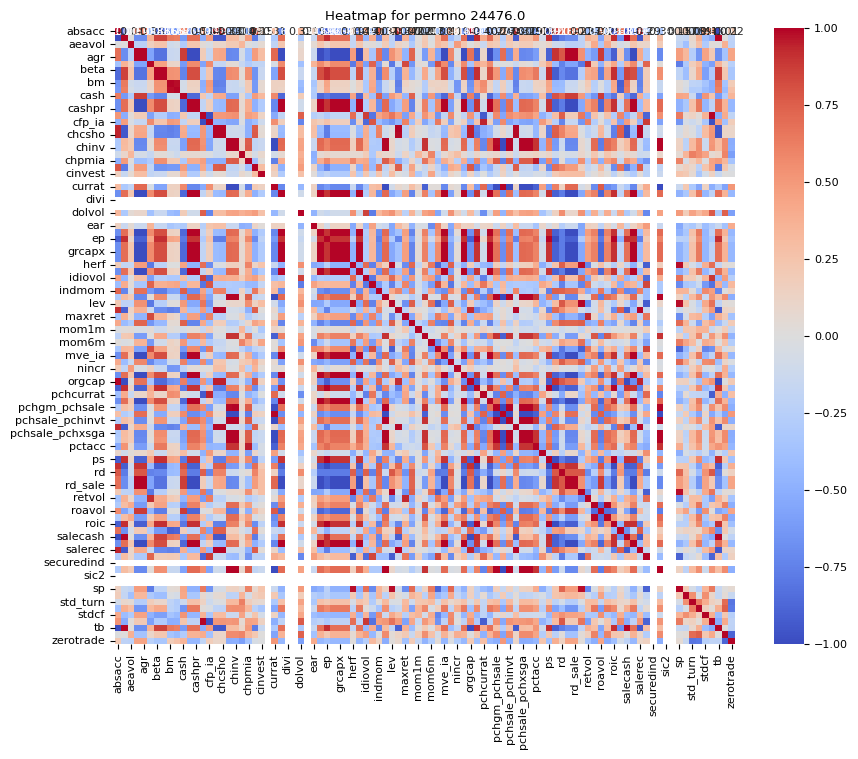

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


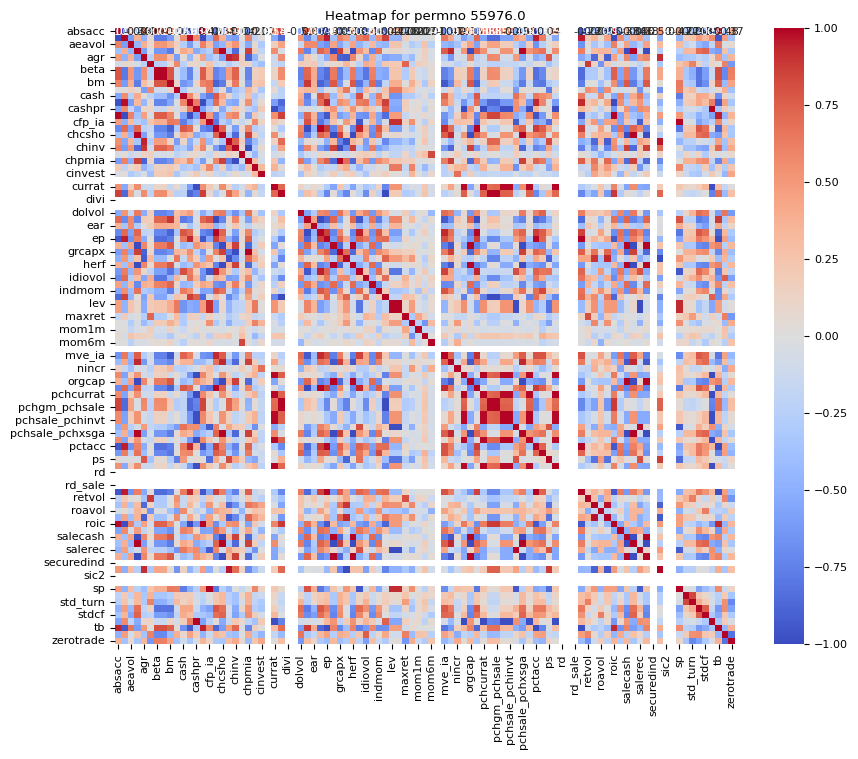

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


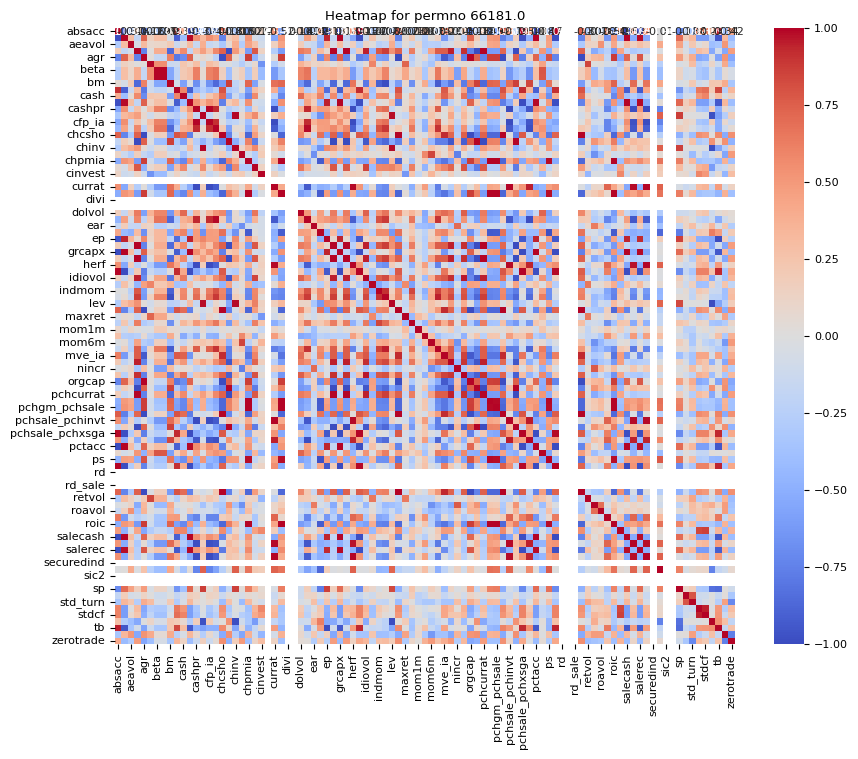

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


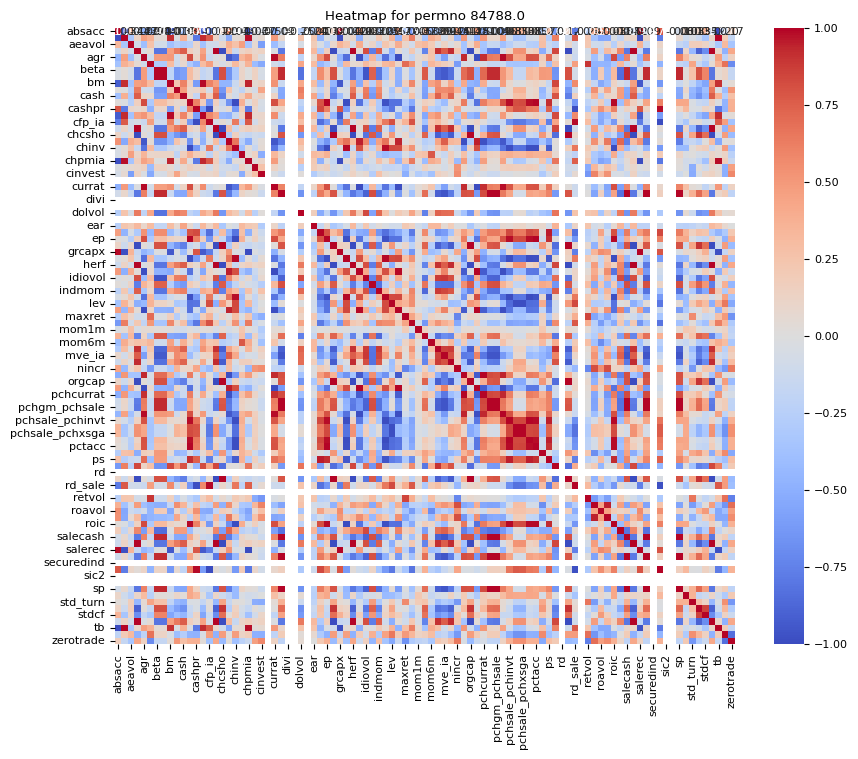

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


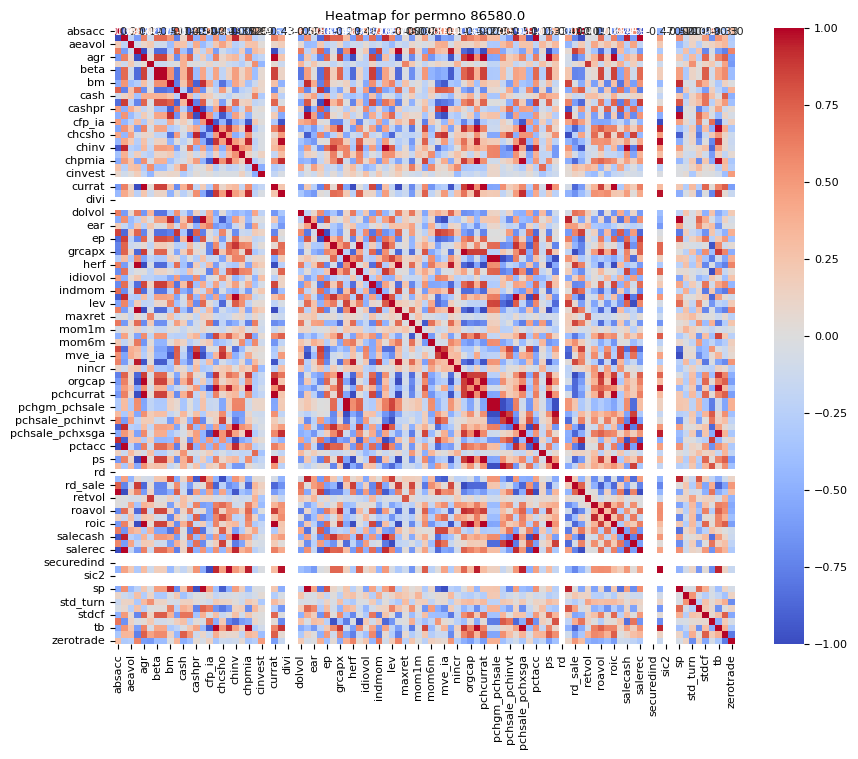

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


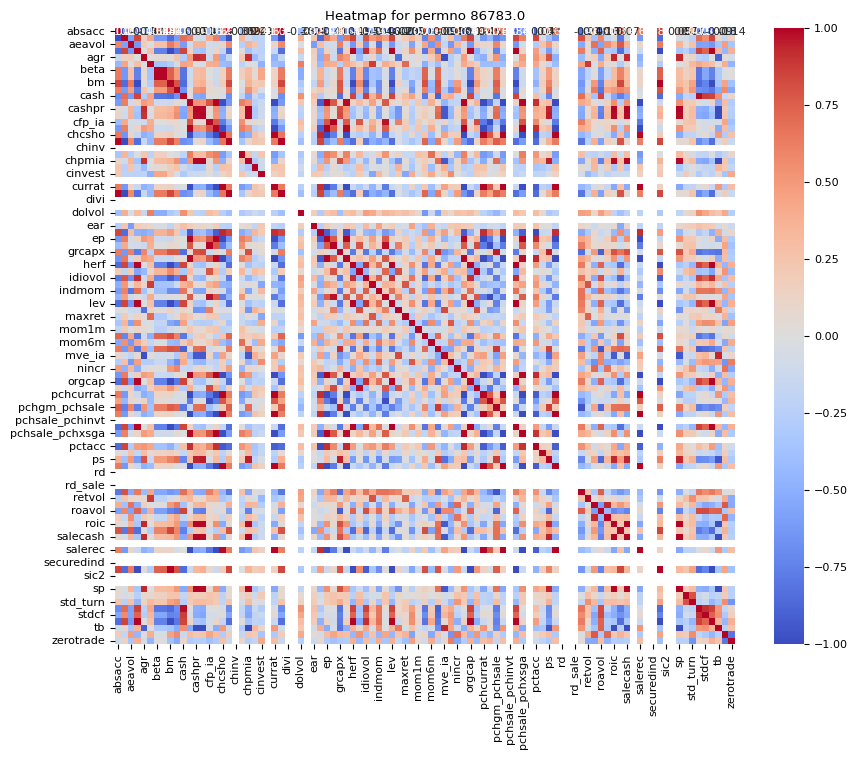

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


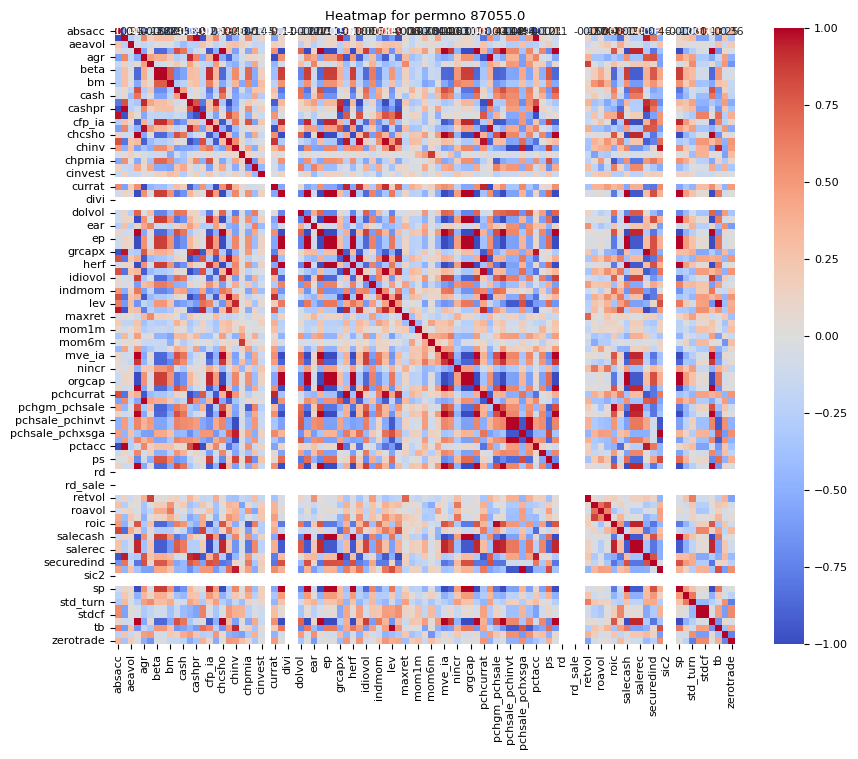

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


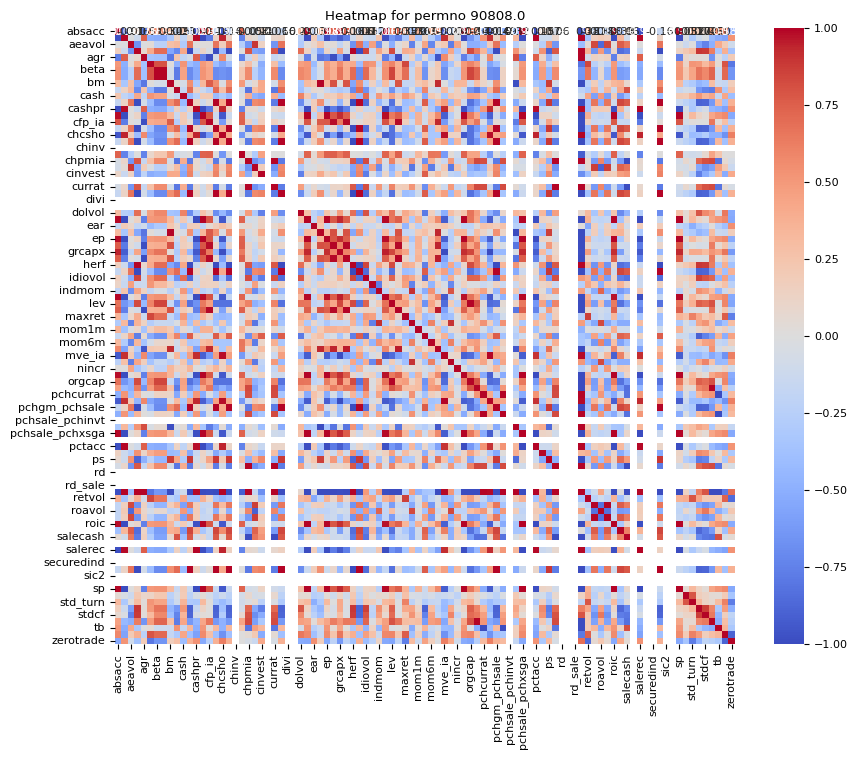

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


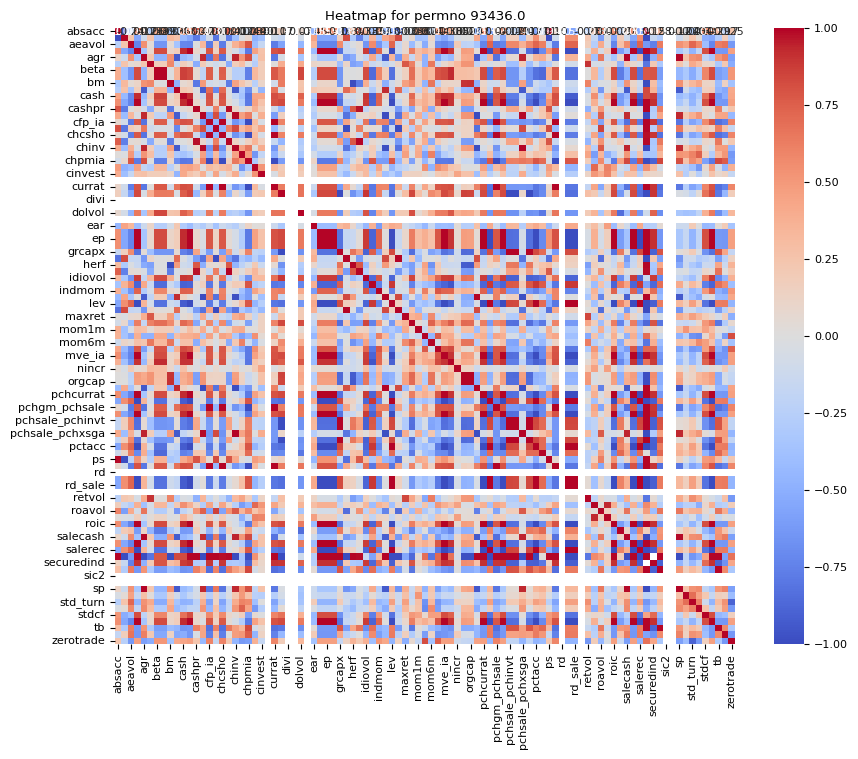

In [34]:
# Get the unique 'permno' values
permnos = pd_merged_standardized.index.get_level_values('permno').unique()

# For each 'permno', create a heatmap of the features
for permno in permnos:
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd_merged_standardized.loc[permno].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Heatmap for permno {permno}')
    plt.show()

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/773212213.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


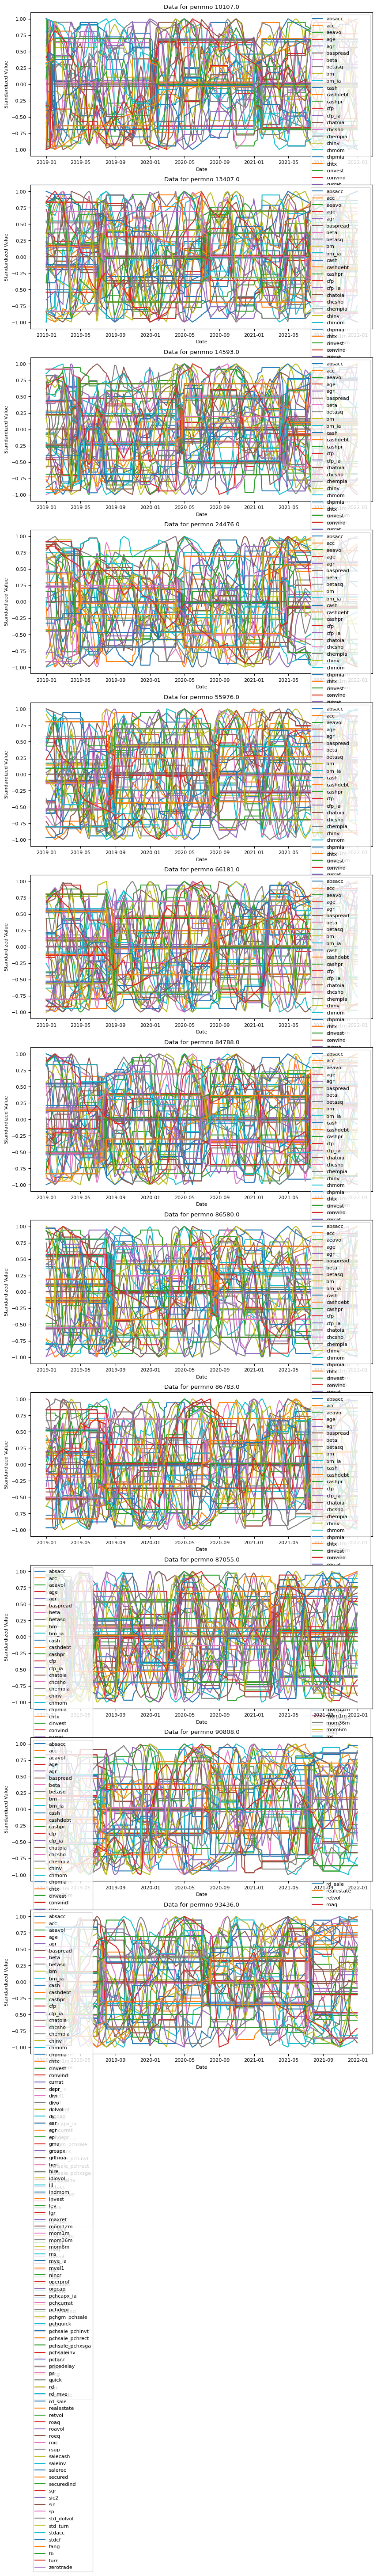

In [35]:
import matplotlib.pyplot as plt

# Get unique 'permno' values
permnos = pd_merged_standardized.index.get_level_values('permno').unique()

# Create a new figure with subplots for each 'permno'
fig, axs = plt.subplots(len(permnos), 1, figsize=(10, 60))  # Adjust the size as needed

# Iterate over the unique 'permno' values
for i, permno in enumerate(permnos):
    # Select the rows with the current 'permno' value
    df = pd_merged_standardized.loc[permno]
    
    # Plot each column
    for column in df.columns:
        axs[i].plot(df.index.get_level_values('DATE'), df[column], label=column)

    # Set the title and labels
    axs[i].set_title(f'Data for permno {permno}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Standardized Value')

    # Add a legend
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Saving all the firm characteristics standardized

In [37]:
# Saving file
standardize_firm_charac = Path.cwd().parent.parent / "Data/Firm_variables/daily_firm_data_standardize_new.parquet"

save_parquet = False
if save_parquet or not os.path.exists(standardize_firm_charac):
    all_daily_dfs.to_parquet(standardize_firm_charac)

In [38]:
# Check for NaN values column-wise
nan_columns = all_daily_dfs.isnull().sum()
print("Number of NaN values in each column:")
print(nan_columns)

# Add columns with NaN values to a list
nan_columns_list = nan_columns[nan_columns > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns_list)

Number of NaN values in each column:
DATE          0
permno        0
mvel1         0
beta          0
betasq        0
             ..
retvol        0
std_dolvol    0
std_turn      0
zerotrade     0
sic2          0
Length: 97, dtype: int64
Columns with NaN values:
['pchsale_pchinvt', 'pchsaleinv', 'rd_mve', 'rd_sale', 'realestate', 'saleinv', 'secured']


In [39]:
firm_permno = all_daily_dfs['permno'].unique()
firm_permno

array([10107., 13407., 14593., 24476., 55976., 66181., 84788., 86580.,
       86783., 87055., 90808., 93436.])

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/1232313304.py:7: DeprecationWarning: `approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  df.approx_n_unique()
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_72983/1232313304.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


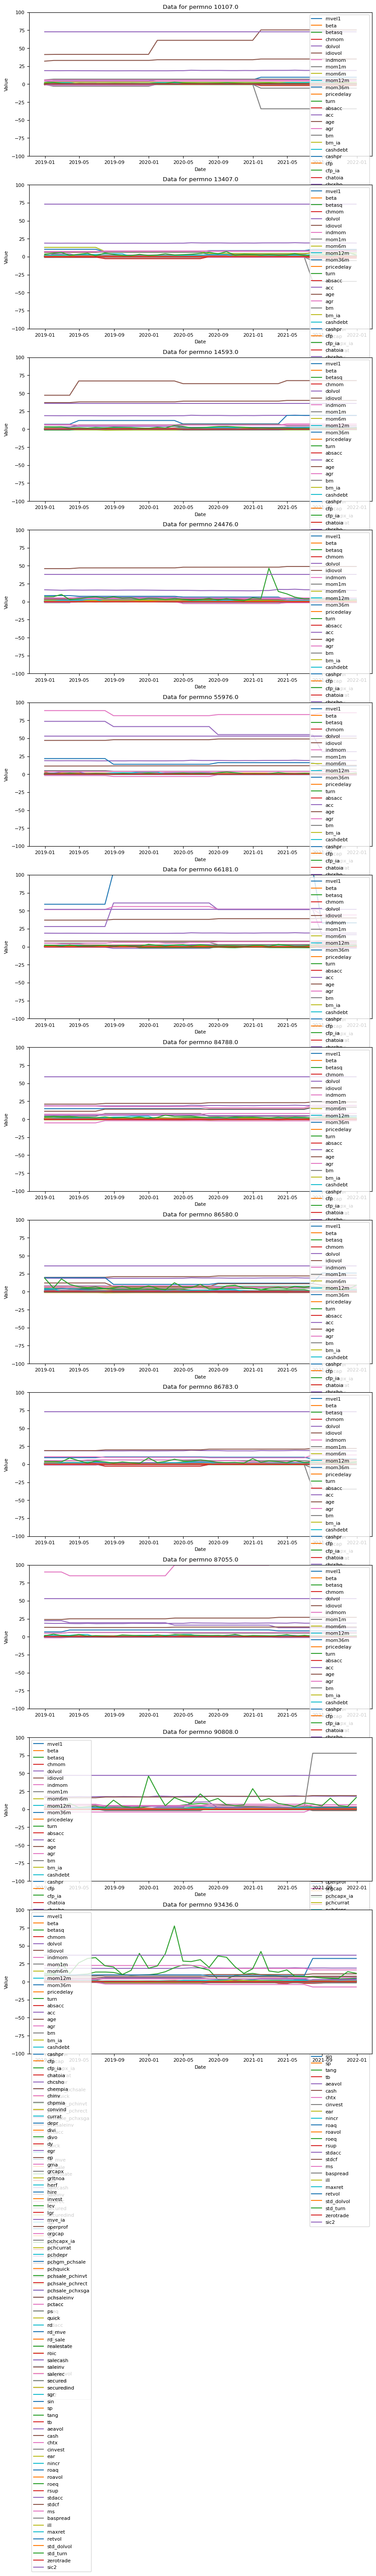

In [40]:
# firm_permno = [10107, 84788, 86580, 13407, 93436, 55976, 87055, 86783, 90808, 24476]
# firm_permno = df['permno'].unique()

df = pl.from_pandas(all_daily_dfs)

# print(df['permno'].unique())
df.approx_n_unique()


import matplotlib.pyplot as plt

# Get unique 'permno' values
permnos = df['permno'].unique()  # Use 'firm_permno' instead of 'permnos'

# Create a new figure with 10 subplots
fig, axs = plt.subplots(len(permnos), 1, figsize=(10, 60))  # Adjust the size as needed

# Iterate over the unique 'permno' values
for i, permno in enumerate(permnos):
    # Select the rows with the current 'permno' value
    df = all_daily_dfs[all_daily_dfs['permno'] == permno]
    
    # Plot each column
    for column in df.columns:
        if column not in ['DATE', 'permno']:  # Exclude 'DATE' and 'permno'
            axs[i].plot(df['DATE'], df[column], label=column)

    # Set the title and labels
    axs[i].set_title(f'Data for permno {permno}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')

    # Limit the y-axis to values between -100 and 100
    axs[i].set_ylim(-100, 100)

    # Add a legend
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()